In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve

sns.set(style='whitegrid', font_scale=1.2)

In [2]:
querystr = ' & '.join(['(HLC{}mag > HLC{}err * 5)'.format(f,f) for f in 'ugriz']) + '& (NSCclass_star > 0.5)'
#querystr += ' & (NSCclass_star > 0.5) & (HLCgmag > HLCgerr * 5) & (HLCrmag > HLCrerr * 5)'
df_s = pd.read_hdf('hlc_nsc_sdss_stars_matches.hdf5', key='data').query(querystr)
df_q = pd.read_hdf('hlc_nsc_sdss_qso_matches.hdf5', key='data').query(querystr)
df_s = df_s.assign(star_or_quasar = 0)
df_q = df_q.assign(star_or_quasar = 1)
df = pd.concat([df_s, df_q], ignore_index=True)

/Users/luxemburg/anaconda3/envs/astroconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(-0.7, 1.7)

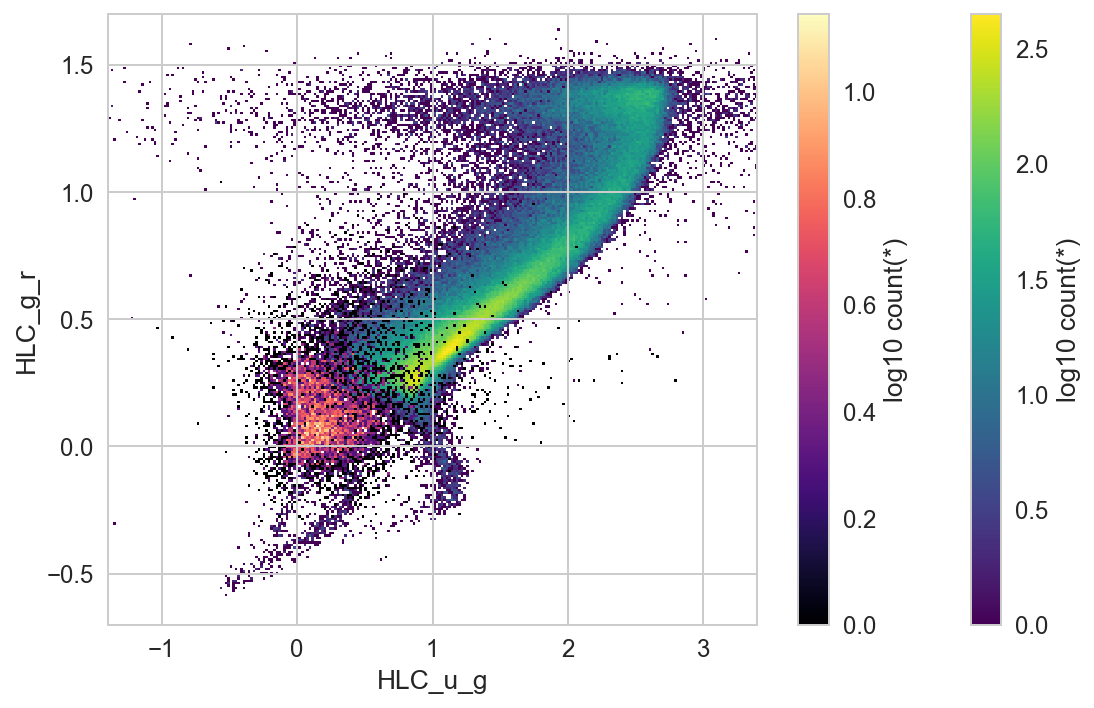

In [3]:
fig, ax = plt.subplots(1, figsize=(8,5))
lim = [[-1.4,3.4], [-0.7,1.7]]
vaex.from_pandas(df_s).plot('HLC_u_g', 'HLC_g_r', f='log10', limits=lim, colormap='viridis')
vaex.from_pandas(df_q).plot('HLC_u_g', 'HLC_g_r', f='log10', limits=lim, colormap='magma')
ax.set_xlim(lim[0])
ax.set_ylim(lim[1])

In [5]:
df_train = df.sample(int(df.shape[0]/10))
df_test = df[~df.index.isin(df_train.index)]

colors = 'HLC_u_g','HLC_g_r','HLC_r_i','HLC_i_z'
X = df_train[[*colors]].values
y = df_train.star_or_quasar.values

X_test = df_test[[*colors]].values
y_test = df_test.star_or_quasar.values

solvers = ['svd','eigen']
linestyles = ['-',':']
colors = ['k', 'grey']
y_scores = []
for solver, ls, c in zip(solvers, linestyles, colors):
    lda = LinearDiscriminantAnalysis(solver=solver, store_covariance=True)
    lda_fit = lda.fit(X, y)
    y_score = lda_fit.predict_proba(X_test)
    y_scores.append(y_score[:,1])

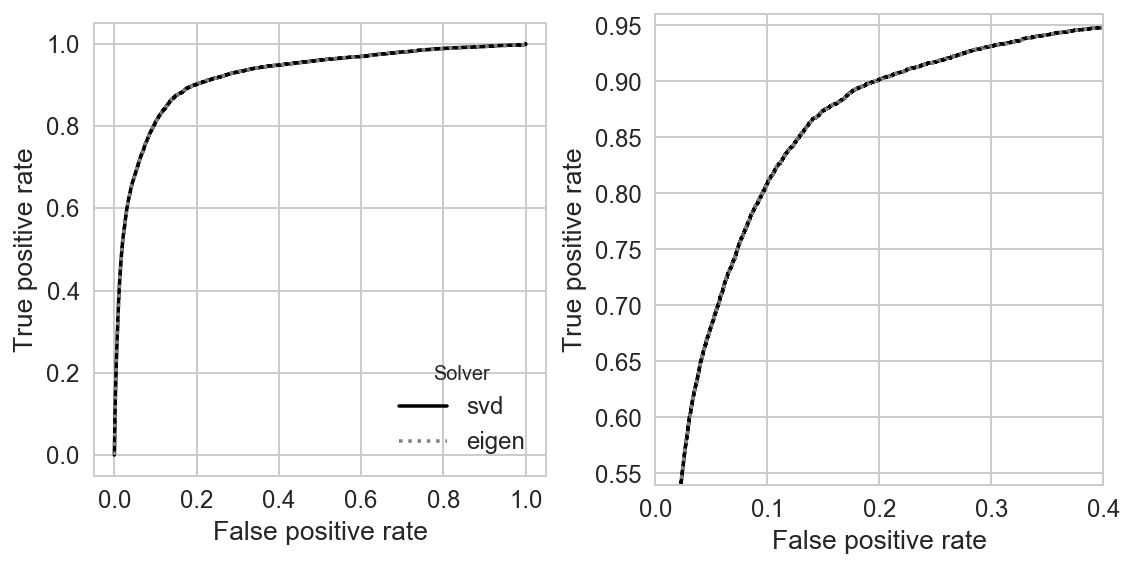

In [6]:
fig, (ax, ax1) = plt.subplots(1,2,figsize=(8,4))
ax.set_aspect('equal')
ax1.set_aspect('equal')
ax1.set_xlim(0,0.4)
ax1.set_ylim(0.54,0.96)
#ax1.set_yticks([0.75,0.8,0.85,0.9,0.95])

for y_score, solver, ls, c in zip(y_scores, solvers, linestyles, colors):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    ax.plot(fpr, tpr, label=solver, color=c, ls=ls)
    ax1.plot(fpr, tpr, label=solver, color=c, ls=ls)
ax.legend(title='Solver')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
fig.tight_layout()